In [59]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
sentences = [
    "i love machine learning",
    "i also like football",
    "i also like virtual worlds"
]

In [18]:
# understanding the tokenizer
def get_padded_sequences_and_word_index(sentences, verbose=False):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    word_index = tokenizer.word_index

    sequences = tokenizer.texts_to_sequences(sentences)
    max_len = max(len(s) for s in sequences)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    if(verbose):
        print(f"max len = {max_len}")
        print(f"word index = {word_index}")
        print(f"padded sequences = {padded_sequences}")
    return padded_sequences, word_index, max_len

In [20]:
seq, word_index, max_len = get_padded_sequences_and_word_index(sentences, True)

max len = 5
word index = {'i': 1, 'also': 2, 'like': 3, 'love': 4, 'machine': 5, 'learning': 6, 'football': 7, 'virtual': 8, 'worlds': 9}
padded sequences = [[0 1 4 5 6]
 [0 1 2 3 7]
 [1 2 3 8 9]]


In [56]:
simple_rnn_model = Sequential([
    Embedding(input_dim = len(word_index) + 1, output_dim=8),
    SimpleRNN(units=32),
    Dense(units=1, activation="sigmoid")
])

simple_rnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

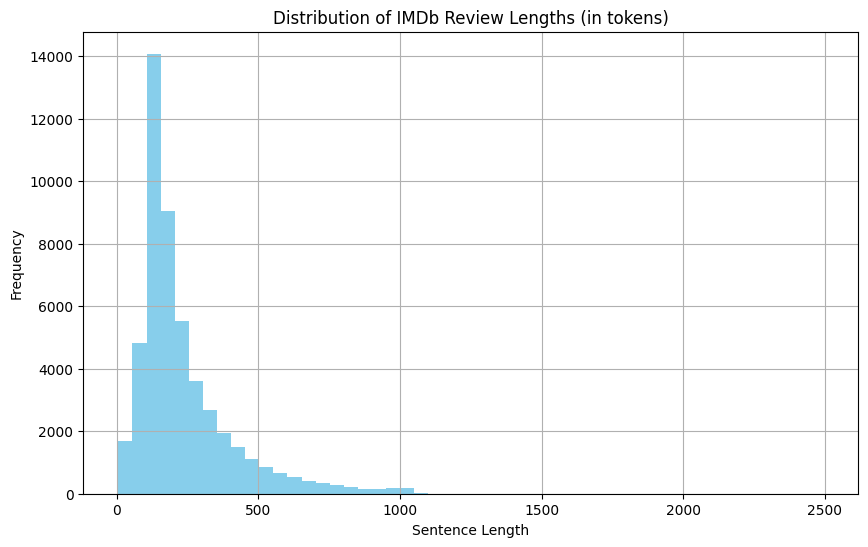

Suggested maxlen (95th percentile): 600
Epoch 1/5


/Users/suyashkumarsingh/.pyenv/versions/3.11.11/envs/eye-for-blind/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.5209 - loss: 0.6910 - val_accuracy: 0.5020 - val_loss: 0.6876
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 162ms/step - accuracy: 0.5548 - loss: 0.6923 - val_accuracy: 0.6146 - val_loss: 0.6526
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - accuracy: 0.6875 - loss: 0.5988 - val_accuracy: 0.8050 - val_loss: 0.4491
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 0.8327 - loss: 0.4102 - val_accuracy: 0.8179 - val_loss: 0.3938
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 160ms/step - accuracy: 0.8728 - loss: 0.3328 - val_accuracy: 0.8478 - val_loss: 0.3671
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8490 - loss: 0.3560
Test Accuracy: 0.8522


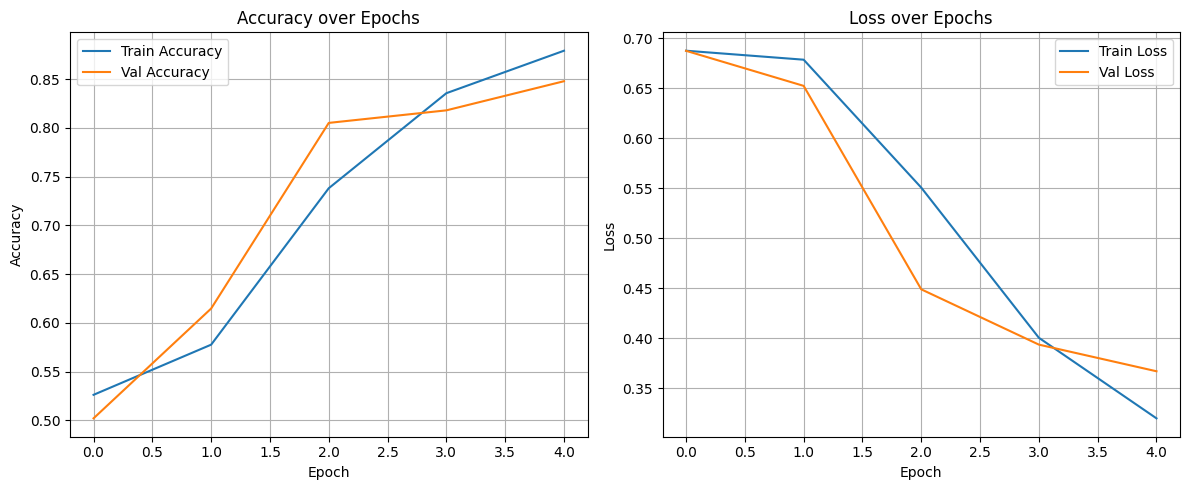

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam

# Step 1: Load dataset
df = pd.read_csv("../datasets/imdb/IMDB Dataset.csv")  # Ensure the CSV is in your working directory

# Step 2: Convert sentiment labels to binary (positive = 1, negative = 0)
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})
texts = df['review'].values
labels = df['label'].values

# Step 3: Tokenize and pad sequences
vocab_size = 10000
maxlen = 200
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

# Step 3: Compute sentence lengths
sentence_lengths = [len(seq) for seq in sequences]

# Step 4: Plot sentence length distribution
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=50, color='skyblue')
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.title("Distribution of IMDb Review Lengths (in tokens)")
plt.grid(True)
plt.show()

# Step 5: Compute the 95th percentile for maxlen
optimal_maxlen = int(np.percentile(sentence_lengths, 95))
print(f"Suggested maxlen (95th percentile): {optimal_maxlen}")

# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

# Step 5: Build the model with LSTM
# model = Sequential([
#     Embedding(input_dim=vocab_size, output_dim=64, input_length=optimal_maxlen),
#     LSTM(64),
#     Dense(1, activation='sigmoid')
# ])

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=optimal_maxlen),  # Increase embedding size
    Bidirectional(LSTM(64, return_sequences=True)),  # Capture both directions
    Dropout(0.5),  # Prevent overfitting
    LSTM(32),  # Add another LSTM layer
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Step 6: Compile and train
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.2)

# Step 7: Evaluate on test set
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()